In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import operator
import os
import warnings
import random
import imageio
import glob
import scipy
import torch
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from skimage.transform import resize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
random.seed(20)

from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# roc-AUC

In [3]:
BasePath = '../diffae/checkpoints/padchest256_autoenc_cls/'
df = pd.read_csv('../padchest/padchest_test_test.csv')

y_true = np.load(os.path.join(BasePath, 'y_true.npy'))
y_pred = np.load(os.path.join(BasePath, 'y_pred.npy'))
PRED_LABEL = df.columns[1:-1]
averages, diseases = [], []
preds, trues = [], []
for i in range(len(PRED_LABEL)):
    try:
        auc = roc_auc_score(y_true[:,i], y_pred[:,i])
    except:
        auc = None
    if auc is not None:
        averages.append(auc)
        diseases.append(PRED_LABEL[i])
        preds.append(y_pred[:,i])
        trues.append(y_true[:,i])
        
result_df = pd.DataFrame({'pathology': diseases,
     'roc-auc': averages
    })

counts = []
for patho in result_df['pathology']:
    count = df[patho].sum()
    counts.append(count)
result_df['y_pred'] = preds
result_df['y_true'] = trues
result_df['# positive'] = counts

In [50]:
result_df[result_df['pathology']=='pleural effusion']

,pathology,roc-auc,y_pred,y_true,# positive
59,pleural effusion,0.943441,"[0.0066836705, 0.03329625, 0.005373083, 0.0074...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",376


In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def boostrap(y_true, y_pred, n_bootstraps):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(0, len(y_pred), len(y_pred) // 2)
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    # mean, ci_lower, ci_upper = mean_confidence_interval(bootstrapped_scores)
    
    return bootstrapped_scores

(array([  7.,  23.,  64., 149., 231., 241., 185.,  83.,  15.,   2.]),
 array([0.47228192, 0.51085658, 0.54943124, 0.5880059 , 0.62658057,
        0.66515523, 0.70372989, 0.74230455, 0.78087921, 0.81945387,
        0.85802853]),
 <a list of 10 Patch objects>)

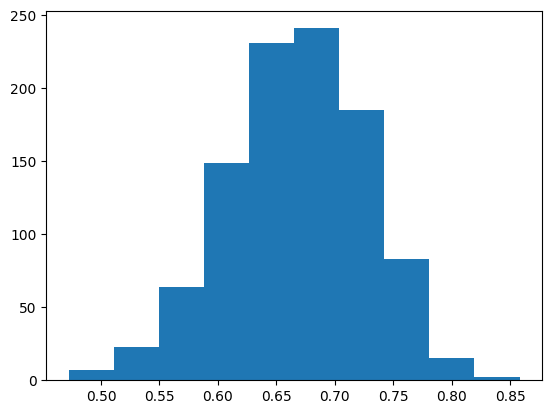

In [21]:
dfs = result_df.iloc[21]
scores = boostrap(dfs['y_true'], dfs['y_pred'], 1000)
plt.hist(scores)

In [20]:
import scipy.stats as st

st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
np.mean(scores)

(0.6523533562287217, 0.6777081258971488)

0.6650307410629352

In [4]:
result_df_ = result_df.sort_values(['roc-auc'], ascending=[False])
result_df_ = result_df_[result_df_['# positive'] > 50]
result_df_['index'] = result_df_.index

result_df_.head()
len(result_df_)

,pathology,roc-auc,y_pred,y_true,# positive,index
131,sternotomy,0.988373,"[0.00033189883, 0.00078165915, 0.013674812, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,131
67,pacemaker,0.978193,"[0.0004537485, 0.00036157694, 0.003192753, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",166,67
19,endotracheal tube,0.977526,"[0.0043576397, 2.2170743e-05, 0.0022954936, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",101,19
8,nsg tube,0.976559,"[0.028529543, 7.7926896e-05, 0.004815316, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",151,8
39,central venous catheter via jugular vein,0.963839,"[0.00061127706, 3.6623471e-06, 0.0048191287, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",71,39


53

In [28]:
result_df.to_csv('./analysis/aucs.csv', index=False)

In [22]:
averages = np.array(averages)
result_df_['roc-auc'].mean()

0.7886187049909389

# counterfactual examples

In [22]:
device = 'cuda:2'
conf = padchest256_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
device = 'cuda:2'
cls_conf = padchest256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 90M
step: 833333
loading latent stats ...
latent step: 37500


In [5]:
class PatchDataset(Dataset):
    def __init__(self, path_to_images, fold='test', sample=0, transform=None):
        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv('../padchest/padchest_test_test.csv')
        # self.df = self.df[self.df['normal']==1]
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(frac=sample, random_state=42)
            print('subsample the training set with ratio %f' % sample)
        self.df = self.df.set_index('ImageID')
        self.PRED_LABEL = self.df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(
            os.path.join(self.path_to_images, self.df.index[idx])
            )
        print(self.df.index[idx])
        image = image.convert('RGB')
        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int')
        if self.transform:
            image = self.transform(image)

        return (image, label)


te_dataset = PatchDataset(path_to_images='../padchest/test',
                        fold='test',
                        transform=transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(256),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))

306704549447961580693205362675398392203_lug40p.png
306704549447961580693205362675398392203_lug40p.png


(193,)

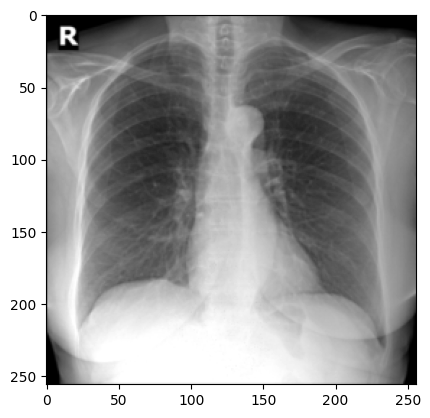

In [26]:
idx = 50
batch, label = te_dataset[idx][0], te_dataset[idx][1]
label.shape
plt.imshow(batch[0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


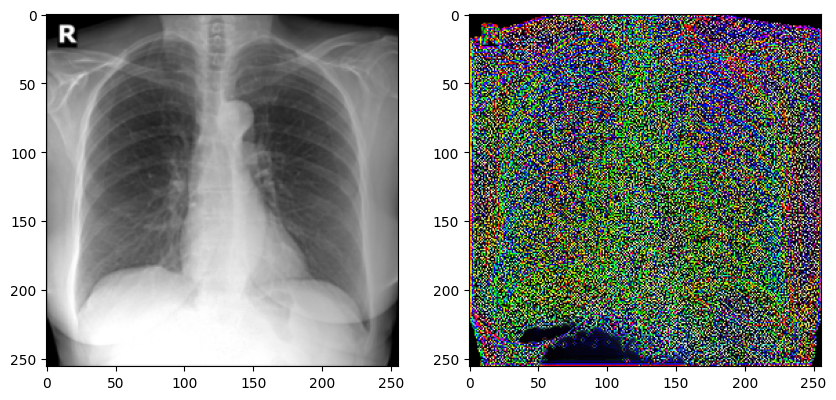

In [27]:
batch = batch[None]
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

0it [00:00, ?it/s]

KeyboardInterrupt: 

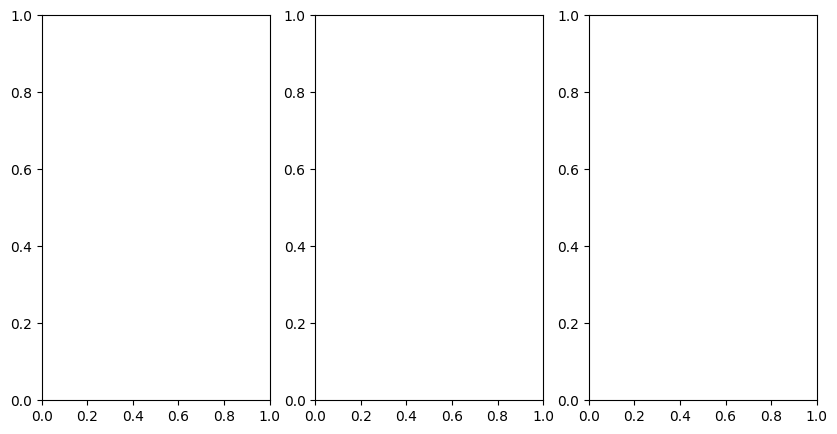

In [36]:
for cls_id, label in tqdm(enumerate(te_dataset.PRED_LABEL)):
    cond2 = cls_model.normalize(cond)
    cond2 = cond2 + 0.6 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
    cond2 = cls_model.denormalize(cond2)
    # torch.manual_seed(1)
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    img = model.render(xT, cond2, T=200)
    ori = (batch + 1) / 2
    _ = ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
    _ = ax[1].imshow(img[0].permute(1, 2, 0).cpu())
    # _ = ax[2].imshow((ori[0,0].cpu() - img[0,0].cpu()).abs(), cmap='hot', vmax=1, vmin=0)
    _ = ax[0].axis('off')
    _ = ax[1].axis('off')
    # _ = ax[2].axis('off')
    # break
    _ = fig.savefig('./imgs_manipulated/padchest/'+label+'.png', bbox_inches='tight', dpi=500)
    _ = plt.close()

# clustermap

In [52]:
from collections import defaultdict

result_df_ = result_df.sort_values(['roc-auc'], ascending=[False])
result_df_ = result_df_[result_df_['# positive'] > 0]
result_df_['index'] = result_df_.index

result_df_.head()
len(result_df_)

d = defaultdict(list)

# for cls_id, label in enumerate(te_dataset.PRED_LABEL):
#     d[label] = cls_model.classifier.weight[cls_id].cpu().detach().numpy()
for n in range(len(result_df_)):
    dfs = result_df_.iloc[n]
    d[dfs['pathology']] = cls_model.classifier.weight[dfs['index']].cpu().detach().numpy()

,pathology,roc-auc,y_pred,y_true,# positive,index
63,central venous catheter via umbilical vein,0.994780,"[3.0512878e-05, 2.95182e-06, 1.2808723e-05, 9....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,63
131,sternotomy,0.988373,"[0.00033189883, 0.00078165915, 0.013674812, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,131
67,pacemaker,0.978193,"[0.0004537485, 0.00036157694, 0.003192753, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",166,67
19,endotracheal tube,0.977526,"[0.0043576397, 2.2170743e-05, 0.0022954936, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",101,19
60,dual chamber device,0.976664,"[0.001721563, 5.62933e-05, 0.0026427435, 0.000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,60


181

In [51]:
result_df_[result_df_['pathology'] == 'pleural effusion']

,pathology,roc-auc,y_pred,y_true,# positive,index
59,pleural effusion,0.943441,"[0.0066836705, 0.03329625, 0.005373083, 0.0074...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",376,59


In [27]:
df_cluster_ = pd.DataFrame(d)
# df_cluster_ = df_cluster_.filter(items = [item.get_text() for item in g.ax_heatmap.get_yticklabels()[-29:]] + ['artificial heart valve', 'artificial mitral heart valve', 'artificial aortic heart valve'])
df_cluster_.head()
len(df_cluster_)

,sternotomy,pacemaker,endotracheal tube,dual chamber device,nsg tube,central venous catheter via jugular vein,single chamber device,mammary prosthesis,pleural effusion,tracheostomy tube,...,flattened diaphragm,rib fracture,unchanged,pseudonodule,calcified granuloma,granuloma,calcified densities,ground glass pattern,nodule,increased density
0,0.344723,0.240222,0.200510,0.384849,0.415242,0.127939,0.170259,0.141028,0.139453,0.206130,...,0.023171,0.261108,0.299659,0.212340,0.423011,0.376706,0.129576,0.356287,0.241406,0.210685
1,-0.172049,0.001725,-0.100436,-0.338361,-0.110086,0.094392,-0.310572,-0.098851,-0.252134,-0.081393,...,-0.030347,-0.030522,-0.386405,-0.019025,0.078662,0.003288,-0.115363,0.035615,-0.086025,-0.223656
2,0.096909,0.050336,0.088144,0.074395,0.040765,0.013178,-0.045307,0.010218,0.062981,0.012681,...,-0.007625,0.082272,0.146435,0.130114,0.101103,0.086528,0.111488,0.084941,0.042284,0.004537
3,-0.003534,-0.099615,0.234790,0.082262,-0.016348,-0.081979,0.055588,0.138965,-0.209241,-0.038038,...,0.017478,0.081021,-0.071532,-0.030536,-0.026646,0.084716,0.074885,-0.144019,0.083573,0.137439
4,-0.148566,-0.191244,-0.247318,-0.257282,0.056011,0.075688,0.007656,-0.080226,-0.186835,0.069638,...,-0.004402,-0.026303,-0.063346,-0.016332,0.110645,0.285494,-0.030502,-0.214146,-0.003519,-0.092303


512

In [55]:
df_cluster.head()

,total atelectasis,reservoir central venous catheter,lipomatosis,subacromial space narrowing,surgery neck,hilar congestion,suboptimal study,miliary opacities,mediastinal shift,nsg tube,...,alveolar pattern,artificial heart valve,reticular interstitial pattern,pneumothorax,hilar enlargement,cardiomegaly,hiatal hernia,dextrocardia,hydropneumothorax,aortic endoprosthesis
0,0.413524,0.241160,0.269487,0.244951,0.348412,0.012009,0.020392,0.381118,0.415242,-0.015040,...,0.055771,0.136255,0.123164,0.211934,0.028690,0.085550,0.057765,0.338168,0.258319,0.202822
1,-0.062237,-0.283894,-0.126780,0.129174,-0.140691,-0.247986,0.050791,-0.166282,-0.110086,-0.033045,...,-0.101921,0.210369,-0.042138,-0.174779,-0.177950,-0.060463,0.092426,-0.262288,-0.231770,-0.001720
2,-0.025238,-0.034721,0.042708,0.027004,0.143824,0.029446,-0.019521,0.020149,0.040765,0.087570,...,0.014235,0.130774,0.065196,-0.011459,0.029087,0.013609,0.068819,0.045228,0.052722,0.093466
3,-0.018788,0.196892,-0.098720,0.286276,-0.186294,-0.006234,0.013360,0.140818,-0.016348,-0.068747,...,-0.127003,0.101406,-0.097381,-0.036771,-0.071629,0.090050,0.136045,0.160077,0.121276,-0.169649
4,0.042758,-0.344507,-0.016924,-0.103426,-0.000419,-0.110987,0.033891,-0.290269,0.056011,-0.217522,...,-0.060564,-0.202754,-0.164057,-0.058030,0.030289,-0.001704,-0.032510,-0.357179,-0.155383,-0.085601


193

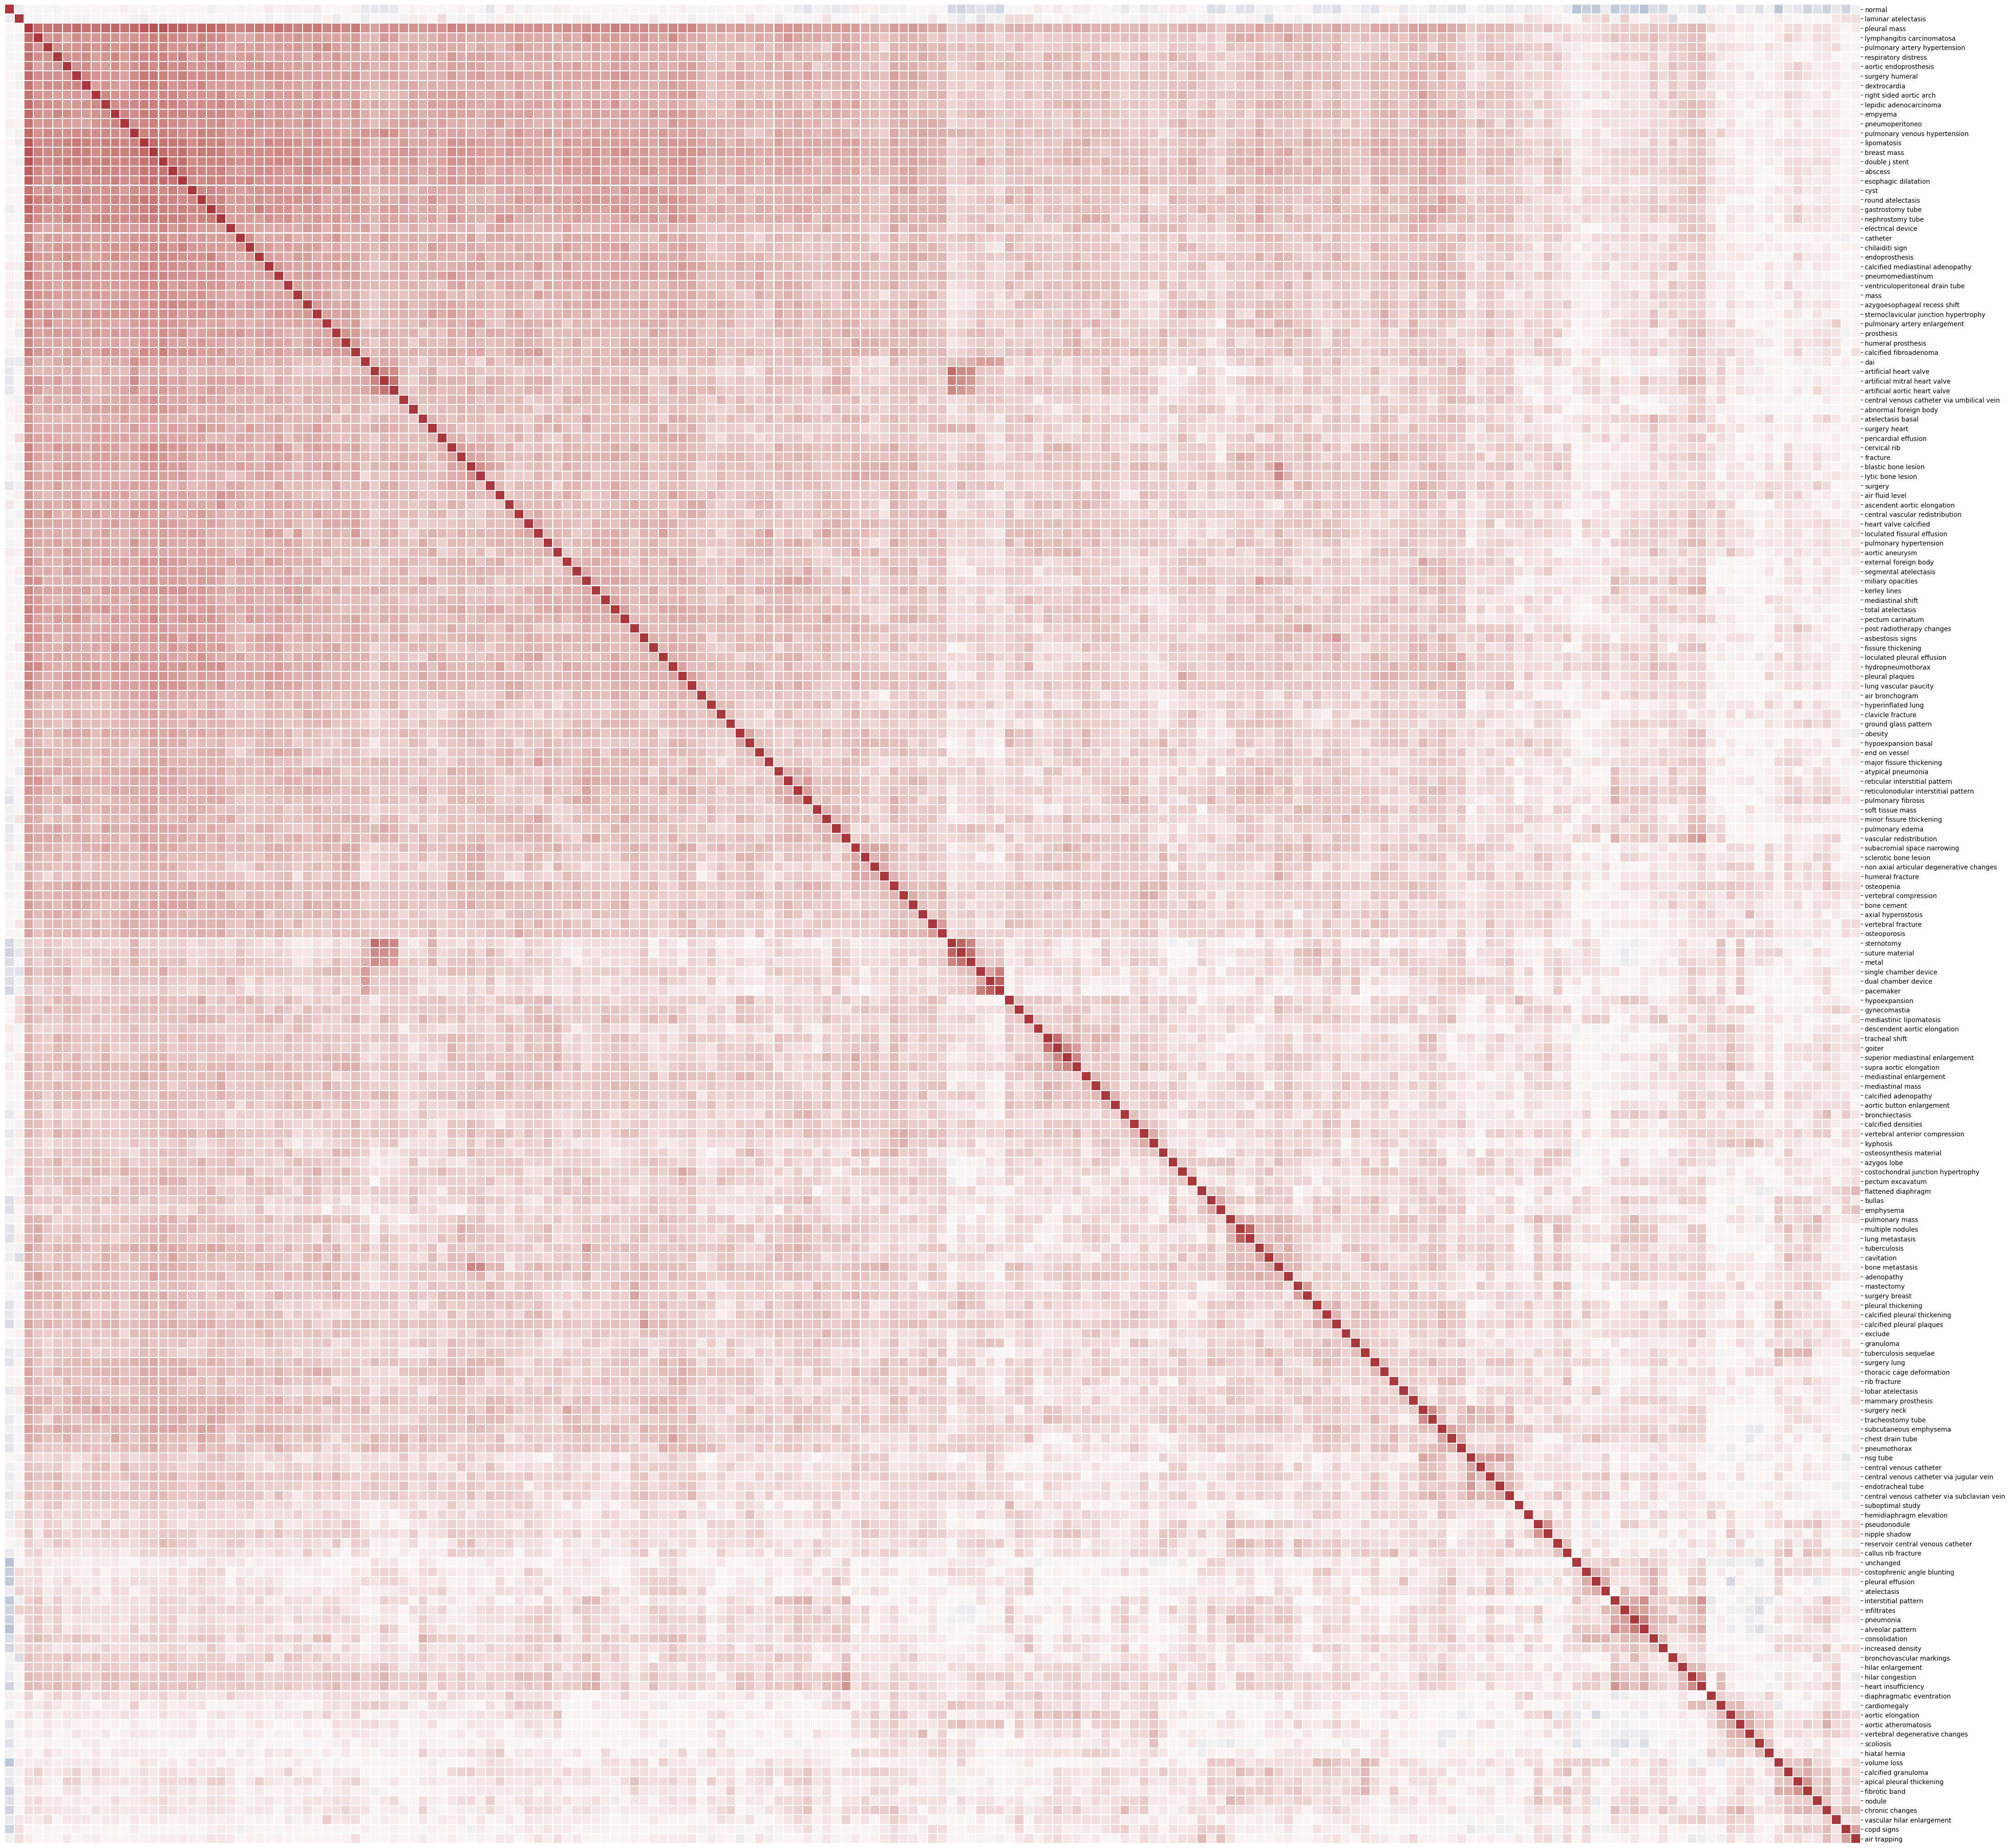

In [65]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

d = defaultdict(list)

for cls_id, label in enumerate(te_dataset.PRED_LABEL):
    d[label] = cls_model.classifier.weight[cls_id].cpu().detach().numpy()
df_cluster = pd.DataFrame(d)

# df_cluster = df_cluster_

correlations = df_cluster.corr()
correlations_array = np.asarray(df_cluster.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

# plt.ioff()

g = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, 
                method='average', 
                cmap="vlag", 
                center=0,
                dendrogram_ratio=(.1, .2),
                # cbar_pos=(.94, .06, .03, .2), 
                linewidths=.75, 
                figsize=(48, 50),
                xticklabels=False,
                # square=True
                   cbar=False
                  )

g.ax_col_dendrogram.remove()
g.ax_row_dendrogram.remove()
# g.figure.savefig("out.png", dpi=400) 
# plt.close(fig)
len(g.ax_heatmap.get_yticklabels())
g.cax.set_visible(False)

# g.ax_cbar.set_position([0.96, 0.49, 0.02, 0.3])